# Demo of Max-value Entropy Search Acqusition

This notebook provides a demo of the max-value entropy search (MES) acquisition function of Wang et al [2017].
https://arxiv.org/pdf/1703.01968.pdf

MES provides the high perfoming optimization of other entropy-based acquisitions. However, unlike standard entropy-search, MES requires a fraction of the computational cost. The computational savings are due to MES seeking to reduce our uncertainty in the value of the function at the optima (a 1-dimensional quantity) rather than uncertainty in the location of the optima (a d-dimensional quantity). Therefore, MES has a computational cost that scales linearly with the parameter space dimension d. 

Our implementation of MES is controlled by two parameters: "num_samples" and "grid_size". "num_samples" controls how many mote-carlo samples we use to calculate entropy reductions. As we only approximate a 1-d integral, "num_samples" does not need to be large or be increased for problems with large d (unlike standard entropy-search). We recomend values between 5-15. "grid_size" controls the coarseness of the grid used to approximate the distribution of our max value and so must increase with d. We recommend 10,000*d. Note that as the grid must only be calculated once per BO step, the choice of "grid_size" does not have a large impact on computation time.  


In [1]:
### General imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import GPy
import time

### Emukit imports
from emukit.test_functions import forrester_function
from emukit.core.loop.user_function import UserFunctionWrapper
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.bayesian_optimization.acquisitions import EntropySearch, ExpectedImprovement, MaxValueEntropySearch
from emukit.model_wrappers.gpy_model_wrappers import GPyModelWrapper
### --- Figure config
LEGEND_SIZE = 15

Set up our toy problem (1D optimisation of the forrester function) and collect 3 initial points.

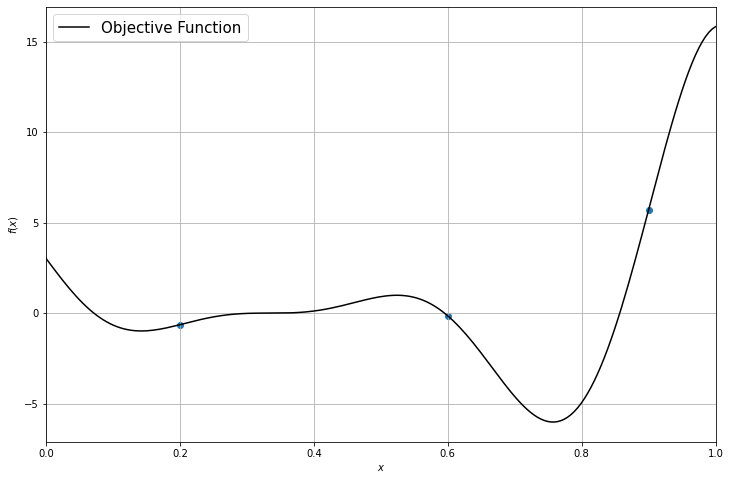

In [2]:
target_function, space = forrester_function()
x_plot = np.linspace(space.parameters[0].min, space.parameters[0].max, 200)[:, None]
y_plot = target_function(x_plot)
X_init = np.array([[0.2],[0.6], [0.9]])
Y_init = target_function(X_init)
plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.scatter(X_init,Y_init)
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)
plt.show()

Fit our GP model to the observed data. 

In [3]:
gpy_model = GPy.models.GPRegression(X_init, Y_init, GPy.kern.RBF(1, lengthscale=0.08, variance=20), noise_var=1e-10)
emukit_model = GPyModelWrapper(gpy_model)


Lets plot the resulting acqusition functions for the chosen model on the collected data. Note that MES takes a fraction of the time of ES to compute (plotted on a log scale). This difference becomes even more apparent as you increase the dimensions of the sample space.

 /Users/henrymoss/Documents/PhD/Code/emukit/emukit/bayesian_optimization/acquisitions/entropy_search.py:70: RuntimeWarning:divide by zero encountered in log


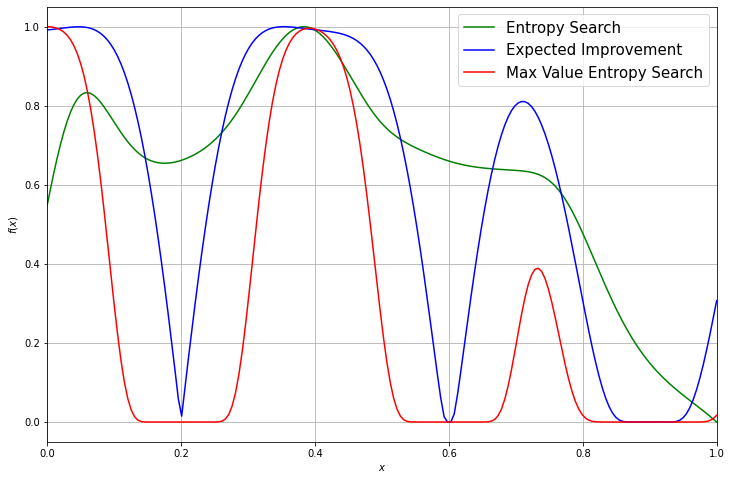

Text(0, 0.5, 'Calculation Time (secs)')

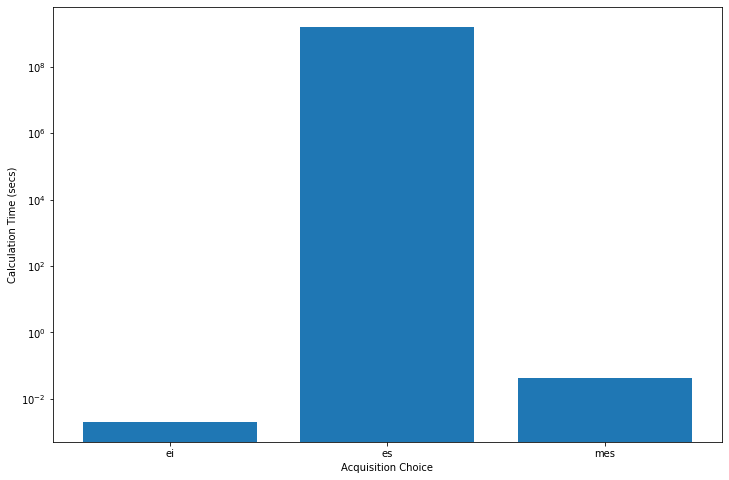

In [4]:
ei_acquisition = ExpectedImprovement(emukit_model)
es_acquisition = EntropySearch(emukit_model,space)
mes_acquisition = MaxValueEntropySearch(emukit_model,space)
t_0=time.time()
ei_plot = ei_acquisition.evaluate(x_plot)
t_ei=time.time()-t_0
es_plot = es_acquisition.evaluate(x_plot)
t_es=time.time()-t_ei
mes_plot = mes_acquisition.evaluate(x_plot)
t_mes=time.time()-t_es
plt.figure(figsize=(12, 8))
plt.plot(x_plot, (es_plot - np.min(es_plot)) / (np.max(es_plot) - np.min(es_plot)), "green", label="Entropy Search")
plt.plot(x_plot, (ei_plot - np.min(ei_plot)) / (np.max(ei_plot) - np.min(ei_plot)), "blue", label="Expected Improvement")
plt.plot(x_plot, (mes_plot - np.min(mes_plot)) / (np.max(mes_plot) - np.min(mes_plot)), "red", label="Max Value Entropy Search")
plt.legend(loc=1, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)
plt.show()
plt.figure(figsize=(12, 8))
plt.bar(["ei","es","mes"],[t_ei,t_es,t_mes])
plt.xlabel("Acquisition Choice")
plt.yscale('log')
plt.ylabel("Calculation Time (secs)")
